In [2]:
# Download the text corpus

import urllib.request

url = 'http://www.gutenberg.org/cache/epub/14066/pg14066.txt'
response = urllib.request.urlopen(url)
text_data = response.read()
text_corpus = str(text_data, 'utf-8')

# print the number of symbols in the corpus
print(len(text_corpus))

# check the first 300 symbols
text_corpus[0:300]

152084


'\ufeffThe Project Gutenberg eBook, Everyday Foods in War Time, by Mary Swartz\r\nRose\r\n\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this e'

In [3]:
from keras.preprocessing import text

# split the corpus to words, and remove special characters
all_words = text.text_to_word_sequence(text_corpus, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r“”’‘')

# see the first 25 words, and the total number of words in the corpus
print(all_words[0:25])
len(all_words)

Using TensorFlow backend.


['\ufeffthe', 'project', 'gutenberg', 'ebook', 'everyday', 'foods', 'in', 'war', 'time', 'by', 'mary', 'swartz', 'rose', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost']


25911

In [7]:
# leave only words with independent semantic value; i.e., remove stopwords
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it",
              "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
              "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against",
              "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there",
              "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
              "just", "don", "should", "now"]

words = [word for word in all_words if word not in stop_words]

# see the total word length of the corpus, ex stopwords
print(len(words))
# see first 25 non-stopword words
print(words[0:25])

15365
['\ufeffthe', 'project', 'gutenberg', 'ebook', 'everyday', 'foods', 'war', 'time', 'mary', 'swartz', 'rose', 'ebook', 'use', 'anyone', 'anywhere', 'cost', 'almost', 'restrictions', 'whatsoever', 'may', 'copy', 'give', 'away', 're', 'use']


In [8]:
# create an index for the words, where each unique word has a unique ID number (index)
# tokens are word + id
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(words)

# create the forward and inverse dictionaries
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

# add an end-of-sentence token
vocab_size = len(word2id) + 1

# display a few examples from the tokenizer dictionary

wids = [word2id[w] for w in words]
print('Word Count:', len(wids))
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:30])

Word Count: 15365
Vocabulary Size: 3216
Vocabulary Sample: [('1', 1), ('2', 2), ('milk', 3), ('one', 4), ('food', 5), ('cup', 6), ('water', 7), ('4', 8), ('fat', 9), ('meat', 10), ('add', 11), ('gutenberg', 12), ('salt', 13), ('teaspoon', 14), ('may', 15), ('bread', 16), ('project', 17), ('sugar', 18), ('diet', 19), ('3', 20), ('cups', 21), ('butter', 22), ('well', 23), ('vegetables', 24), ('work', 25), ('foods', 26), ('flour', 27), ('corn', 28), ('tm', 29), ('much', 30)]


In [13]:
from keras.preprocessing.sequence import skipgrams
import numpy as np

# Skipgram with Negative Sampling
# generate skip-grams with the Keras utility, with a window size of 5-10?
# skip grams are pairs of words, with an associated target of 1, if the pair are
# found in the window size of each other, and 0 if they are not, and so the 
# whole language model problem becomes a self-supervised algorithm

skip_grams = [skipgrams(wids, vocabulary_size=vocab_size, window_size=2)]

# view sample skip-grams
pairs, labels = np.asarray(skip_grams[0][0]), np.asarray(skip_grams[0][1])
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(orange (662), lemon (172)) -> 1
(ten (664), especially (269)) -> 1
(half (31), hours (170)) -> 1
(department (413), sauté (2801)) -> 0
(pieces (175), layers (1567)) -> 0
(lean (368), advised (2100)) -> 0
(substitutes (195), lard (272)) -> 1
(syrup (75), calamity (2052)) -> 0
(half (31), equal (533)) -> 0
(cranberry (2767), date (575)) -> 1







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       321600      word_input[0][0]                 
                                                                 context_input[0][0]              
____________________________________________________________________________________________

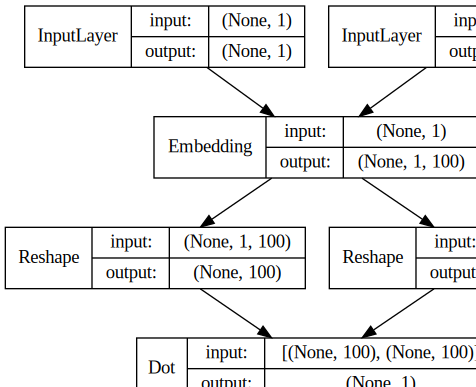

In [15]:
# create the model architecture

import keras
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras import layers

# set the latent dimension size - this latent vector will encode the semantics
# of each word
embed_size = 100

word_inputs = layers.Input([1,], name='word_input')

context_inputs = layers.Input([1,], name='context_input')

# the neural network trains the embedding layer, which contains the latent
# representations of all words in the corpus, so is 3215 x 100 in size
embed = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1)

# use the single embed layer for both the word and context embeddings

word_embed = embed(word_inputs)

context_embed = embed(context_inputs)

word_reshape = Reshape((embed_size,))(word_embed)

context_reshape = Reshape((embed_size,))(context_embed)

# the Dot layer is the similarity measure, followed by a sigmoid activation
# as displayed in the diagram below

merge = Dot(axes = 1, normalize = True)([word_reshape, context_reshape])

dense = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(merge)

model = keras.Model(inputs = [word_inputs, context_inputs], outputs = dense)

model.compile(loss="binary_crossentropy", optimizer="rmsprop")

# view model summary
model.summary()

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [16]:
# train the model for 15 epochs

batch_size = 64
epochs = 15

model.fit(
    x=[pairs[:,0],pairs[:,1]],
    y=labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2,
    shuffle=True
)




Train on 98326 samples, validate on 24582 samples
Epoch 1/15





98326/98326 [==============================] - 8s 81us/step - loss: 0.6726 - val_loss: 0.6596
Epoch 2/15
98326/98326 [==============================] - 7s 73us/step - loss: 0.5651 - val_loss: 0.6457
Epoch 3/15
98326/98326 [==============================] - 7s 73us/step - loss: 0.4735 - val_loss: 0.6455
Epoch 4/15
98326/98326 [==============================] - 7s 75us/step - loss: 0.4038 - val_loss: 0.6529
Epoch 5/15
98326/98326 [==============================] - 8s 77us/step - loss: 0.3515 - val_loss: 0.6671
Epoch 6/15
98326/98326 [==============================] - 8s 77us/step - loss: 0.3119 - val_loss: 0.6843
Epoch 7/15
98326/98326 [==============================] - 8s 79us/step - loss: 0.2819 - val_loss: 0.7008
Epoch 8/15
98326/98326 [==============================] - 8s 78us/step - loss: 0.2591 - val_loss: 0.7177
Epoch 9/15
98326/98326 [==============================] - 8s 79us/step - loss: 0.2414 - val_loss: 0.73

In [17]:
# check the created embeddings as a dataframe

import pandas as pd

# get the weights by extracting the embedding layer from the trained model
weights = model.layers[-5].get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(3215, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
1,-0.072909,0.019825,-0.007141,0.060088,-0.051375,0.190954,0.125357,0.149467,0.175571,-0.095964,0.075636,0.018884,0.088015,0.051566,-0.111871,-0.219616,0.013046,-0.119471,0.129561,0.195791,-0.068884,-0.037262,0.113075,-0.139861,-0.008489,-0.139104,-0.018023,-0.114215,-0.097435,-0.162742,0.158162,0.200547,0.067446,0.044481,-0.160627,-0.065632,-0.145334,-0.174004,0.110052,-0.020316,...,-0.023981,-0.219380,0.078180,-0.217300,0.085041,-0.182830,-0.075914,-0.120019,0.046566,0.047690,-0.156200,-0.046808,-0.221729,0.035525,0.033256,-0.204091,-0.074184,0.086690,0.112138,0.131340,-0.062747,-0.166148,0.117966,-0.122126,-0.045149,-0.167504,-0.071733,-0.137078,0.248715,0.213625,-0.046861,-0.182441,0.080535,-0.076507,0.105959,0.155848,-0.085949,0.060687,-0.094231,-0.180648
2,-0.074744,0.143358,-0.093729,0.169246,-0.196397,-0.086590,-0.036246,0.106903,-0.133195,0.158323,0.101614,0.118634,-0.089872,-0.066172,0.074193,0.080635,0.073234,0.104610,-0.106709,-0.072534,-0.147650,0.104185,0.057151,-0.123703,-0.175238,0.028815,0.025760,-0.002354,-0.024067,0.137016,-0.125869,-0.149297,0.083858,0.088689,-0.066314,-0.087912,-0.037630,0.121791,-0.050397,0.055166,...,0.127436,0.174135,0.131380,-0.027441,-0.017621,0.129132,0.141263,0.139219,0.087059,0.067882,0.095847,-0.131302,-0.010714,-0.046004,0.117719,-0.079638,0.020650,-0.074060,0.073518,0.084540,0.151786,0.102925,0.038106,0.019898,0.071206,0.006687,0.073693,-0.088099,0.015728,-0.149281,0.108862,0.015630,0.130706,0.054496,-0.142024,0.162879,0.063987,0.097060,-0.151041,-0.089756
milk,-0.106486,0.085986,0.057053,0.127669,0.108930,0.030028,-0.116592,-0.142169,0.131443,0.174510,-0.077262,-0.120283,-0.127833,-0.142838,0.136057,-0.114417,0.147386,-0.122508,0.055848,0.136342,0.013556,-0.151769,-0.099303,0.070902,0.070390,-0.108092,0.071684,-0.130982,-0.038978,-0.130484,-0.128876,-0.179958,-0.100698,0.156909,0.140357,0.114915,0.010765,-0.050475,0.082171,0.171060,...,0.043872,0.113975,-0.056572,-0.094534,0.115408,0.160483,-0.115920,0.116151,-0.105829,0.199499,-0.090375,0.125086,-0.102607,-0.165200,-0.189712,-0.043247,-0.029866,0.067722,-0.056339,0.002330,-0.139084,0.087619,-0.175278,-0.088049,0.213401,-0.153408,0.088215,0.100418,-0.145435,-0.162522,-0.149494,-0.029465,-0.155037,0.119490,0.074175,0.109793,0.086686,0.127584,0.032139,0.093683
one,0.158439,-0.092404,0.148978,0.131154,-0.123054,-0.128632,0.111148,0.071838,-0.103850,0.136648,-0.184108,0.061584,-0.003689,0.053324,-0.133177,0.129539,-0.111082,0.081830,0.116664,-0.090770,0.130520,-0.160997,0.112464,-0.072035,-0.058468,0.078565,0.167758,-0.109367,-0.071320,0.126953,-0.115932,-0.076941,0.130398,0.057262,-0.083738,0.127319,0.095782,-0.149758,0.079636,-0.065653,...,0.085915,0.055365,0.018986,0.038781,0.144785,-0.112182,-0.162147,0.095942,-0.007149,0.124770,-0.206521,-0.110223,0.050844,0.089666,0.156417,-0.052048,0.124091,0.158597,-0.127662,0.186651,-0.081284,-0.113675,-0.061295,0.108736,-0.212406,0.103784,0.210104,0.129839,0.122294,0.171327,-0.086047,0.050370,-0.126694,0.177628,0.141252,0.159731,-0.063557,0.147363,-0.070246,-0.137882
food,-0.108327,-0.118577,0.154358,-0.071963,0.028845,0.126713,0.153549,-0.075503,0.124387,0.123777,0.071890,0.129450,-0.131705,0.064077,0.062768,0.125767,-0.136856,0.055710,-0.130055,-0.229728,0.082524,-0.065505,-0.168403,-0.078442,-0.116890,0.100552,-0.095908,-0.124989,-0.097059,-0.045402,-0.154924,0.084947,-0.103485,0.144466,0.088254,-0.093005,-0.088046,-0.126223,0.102764,-0.116977,...,-0.116706,-0.152810,-0.120789,-0.076763,-0.104078,0.097883,0.095252,0.042234,0.121632,-0.113585,-0.000391,0.077066,0.135586,0.123473,-0.062998,-0.163973,-0.169370,-0.056973,-0.059237,-0.138699,-0.147873,-0.086515,0.083842,-0.158943,0.153848,-0.023379,0.065416,0.120349,-0.024906,-0.100247,-0.164473,-0.069726,-0.0

In [21]:
# The above is the quanitification of language semantics! (see presentation?)
# We can then do a few things, like check the top 5 closest words to a sample 

from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['food', 'chef', 'war']}

similar_words

(3215, 3215)


{'chef': ['unsatisfactory', 'expend', 'ultimate', 'simon', '539'],
 'food': ['facts', 'punitive', 'invariably', 'subscribe', 'observed'],
 'war': ['allayed', 'depths', '12mo', 'pennsylvania', 'l']}

In [23]:
# do some bag of words math!

def word_math(word1, word2, word3, num_words):
  new_word = weights[word2id[word1]] - weights[word2id[word2]] + weights[word2id[word3]]
  similarities = [np.dot(new_word, word_vec)/(np.linalg.norm(new_word)*np.linalg.norm(word_vec)) for word_vec in weights]
  closest = np.asarray(similarities).argsort()
  num_words = num_words
  closest_words = []
  for i in range(1, num_words + 1):
    close_word = id2word[closest[i - i*2]]
    closest_words.append(close_word)
  return closest_words

word_math('soup','water','meat', 10)

['soup',
 'country',
 'accessible',
 'alternative',
 'brick',
 'traditions',
 'mistakes',
 'eight',
 'ascii',
 'liability']

#The pre-trained model

In [24]:
# download a pre-trained model

import spacy.cli

#spacy.cli.download("en_core_web_lg")
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [25]:
# create the vector matrix; should contained ~700k words

ids = [x for x in nlp.vocab.vectors.keys()]
vectors = [nlp.vocab.vectors[x] for x in ids]
vectors = np.array(vectors)
vectors.shape

(684830, 300)

In [28]:
# Do some more word math!

def word_math(word1, word2, word3, num_words):
  new_word = nlp(word1).vector.astype('float64') - nlp(word2).vector.astype('float64') + nlp(word3).vector.astype('float64')
  similarities = [np.dot(new_word, word_vec)/(np.linalg.norm(new_word)*np.linalg.norm(word_vec)) for word_vec in vectors]
  closest = np.asarray(similarities).argsort()
  num_words = num_words
  closest_words = []
  for i in range(1, num_words + 1):
    close_word = ids[closest[i - i*2]]
    closest_words.append(nlp.vocab[close_word].text)
  return closest_words

word_math('soup','water','meat', 20)

['MEAT',
 'Meat',
 'meat',
 'chowder',
 'minestrone',
 'Soup',
 'MINESTRONE',
 'Chowder',
 'vichyssoise',
 'soup',
 'VICHYSSOISE',
 'CHOWDER',
 'Minestrone',
 'SOUP',
 'Vichyssoise',
 'Beef',
 'extra-lean',
 'BEEF',
 'Extra-Lean',
 'grassfed']

# Text Classification
# ChatBots
# Sentiment Analysis
# Semantic Search
# Text Summary, Text Generation, Question Answering, etc.